### Imports & config

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from cassandra.cluster import Cluster
import json
from pprint import pprint
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, clear_output
import time
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, to_timestamp
os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_HADOOP_VERSION"] = "without"
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

23/11/28 10:28:50 WARN Utils: Your hostname, Endres-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.42.75.58 instead (on interface en0)
23/11/28 10:28:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/endreasgard/.ivy2/cache
The jars for the packages stored in: /Users/endreasgard/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-211c0b0a-532b-479b-a27c-42dc8ce0e16d;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central


:: loading settings :: url = jar:file:/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-builder;4.13.0 in central
	found org.apache.commons#commons-lang3;3.10 in central
	found com.thoughtworks.paranamer#paranamer;2.8 in central
	found org.sca

In [3]:
cluster = Cluster(['localhost'], port=9042) # connecting to cassandra
session = cluster.connect('fishhealth')

## Pivoting

### Getting data and putting it into pandas

In [4]:
weather_data = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="weather_data", keyspace="fishhealth") \
    .load()

weather_lice = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="weather_lice", keyspace="fishhealth") \
    .load()

lice_data = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="week_summary", keyspace="fishhealth") \
    .load()

locations_data = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="locality_summary", keyspace="fishhealth") \
    .load()

# getting all the tables we have made so far, fun!

In [5]:
lice_df = lice_data.select("*").toPandas()
weather_df = weather_data.select("*").toPandas()
locations_df = locations_data.select("*").toPandas()
weather_lice_df = weather_lice.select("*").toPandas()

# transforming the data to pandas df for easier manipulation
weather_lice_df = weather_lice_df.sort_values(by=['week'])
lice_df = lice_df.sort_values(by=['week'])
locations_df = locations_df.sort_values(by=['week'])

# data comes unsorted when read from cassandra, so we sort it by week

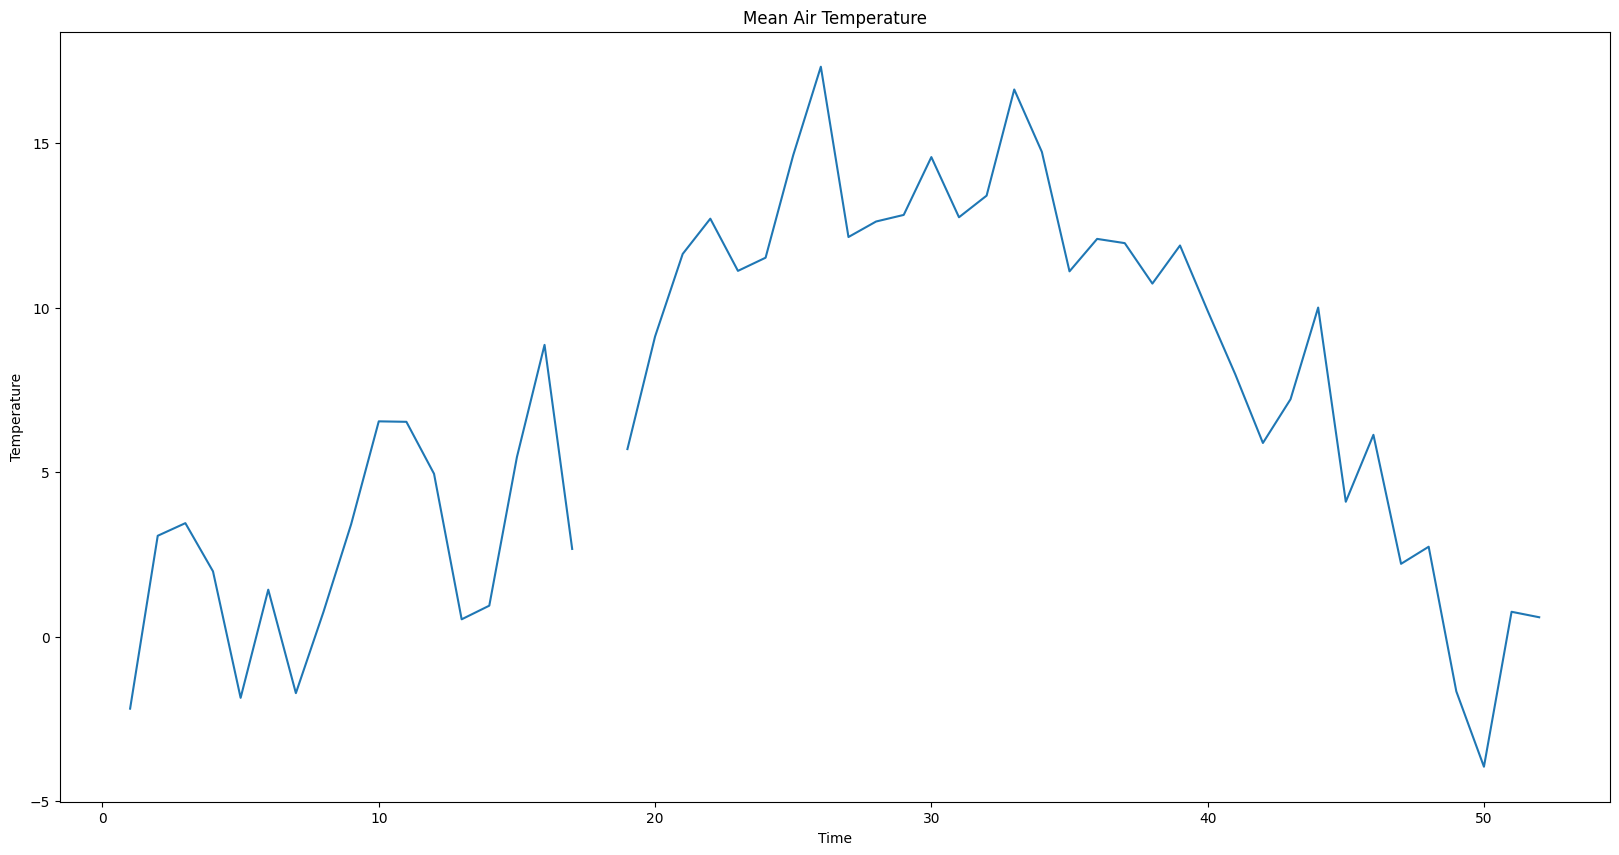

In [6]:
#plot mean_air_temperature in weather_lice_df

plt.figure(figsize=(20,10))
plt.plot(weather_lice_df['week'],weather_lice_df['mean_air_temperature'])
plt.title('Mean Air Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()


In [7]:
lice_df.head()

,week,localityno,avgadultfemalelice,avgmobilelice,avgstationarylice,hasreportedlice,seatemperature,year
40,1,18755,0.05,0.29,0.0,True,6.5,2022
50,2,18755,0.07,0.28,0.0,True,6.0,2022
16,3,18755,0.04,0.29,0.0,True,5.8,2022
43,4,18755,0.05,0.27,0.0,True,4.9,2022
28,5,18755,0.07,0.27,0.0,True,5.6,2022


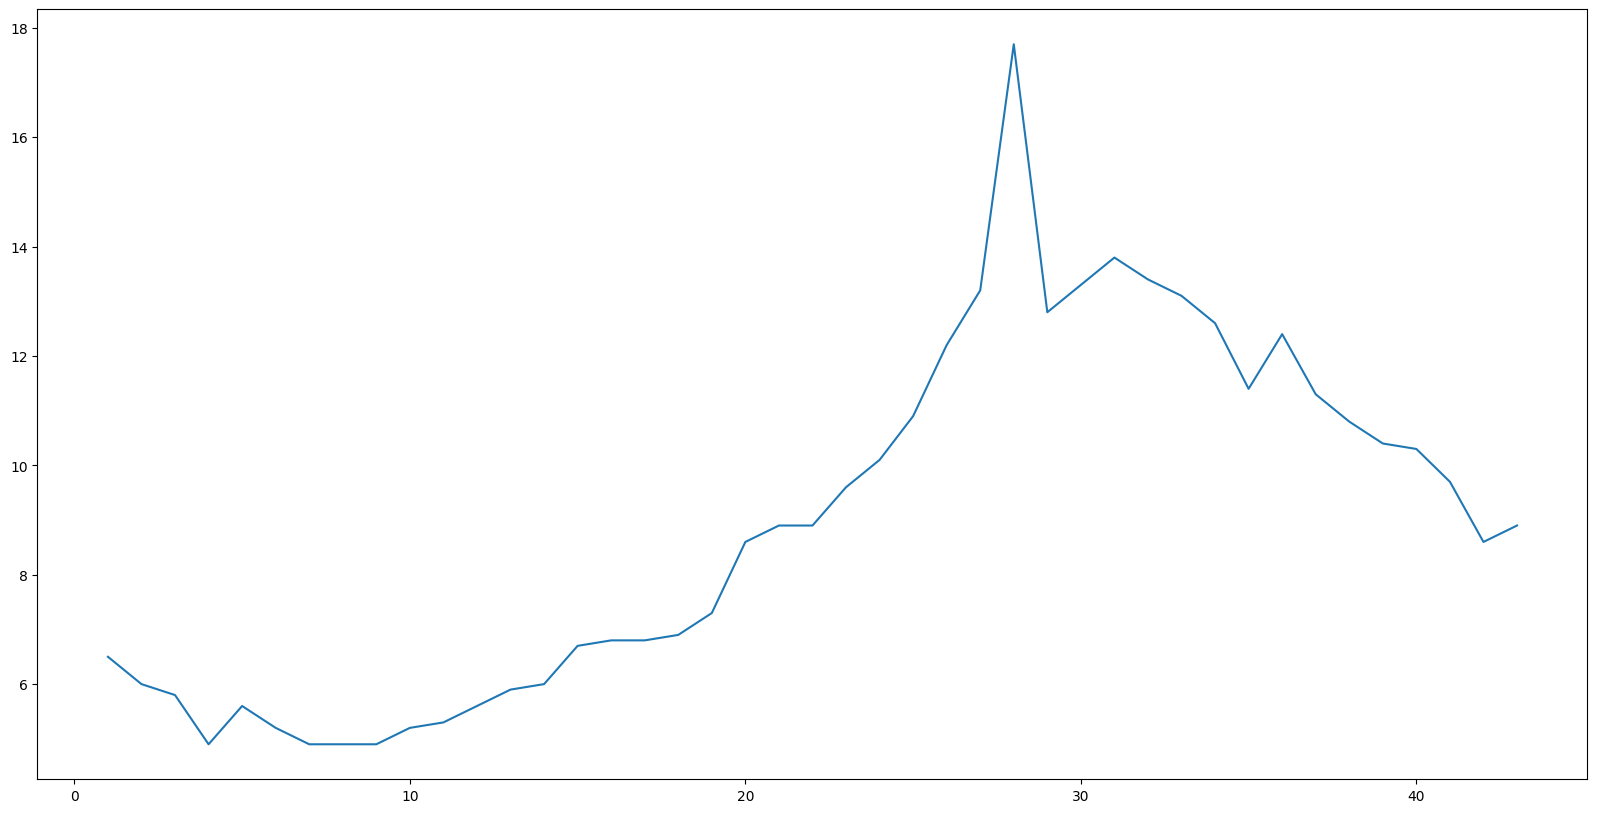

In [8]:
plt.figure(figsize=(20,10))
plt.plot(lice_df['week'],lice_df['seatemperature'])
plt.show()

In [9]:
lice_df.sort_values(by=['week'])
lice_df.tail(10)

,week,localityno,avgadultfemalelice,avgmobilelice,avgstationarylice,hasreportedlice,seatemperature,year
9,42,18755,0.37,1.93,2.72,True,8.6,2022
47,43,18755,0.27,2.42,0.18,True,8.9,2022
13,44,18755,0.05,1.15,0.72,True,NaN,2022
48,45,18755,NaN,NaN,NaN,False,NaN,2022
38,46,18755,NaN,NaN,NaN,False,NaN,2022
11,47,18755,NaN,NaN,NaN,False,NaN,2022
27,48,18755,NaN,NaN,NaN,False,NaN,2022
7,49,18755,NaN,NaN,NaN,False,NaN,2022
0,50,18755,NaN,NaN,NaN,False,NaN,2022
35,51,18755,NaN,NaN,NaN,False,NaN,2022


### Creating the region variable

In [10]:
conditions = [
    (locations_df['lat'] < 63.81),
    (locations_df['lat'] <= 68.85),
    (locations_df['lat'] > 68.85)
]

# Define the corresponding region for each condition.
choices = ['South', 'Middle', 'North']

# Use numpy.select to apply these conditions and choices to the 'latitude' column.
locations_df['region'] = np.select(conditions, choices)

### Grouping

In [11]:
weekly_avg = locations_df.groupby('week')['avgadultfemalelice'].mean().reset_index()
# this will be the weekly avg for the whole country

In [12]:
pivot_table_pd_ila = locations_df.pivot_table(index=['haspd', 'hasila'], values='lat', aggfunc='mean')

In [13]:
pivot_table_week_region = locations_df.pivot_table(index=['week', 'region'], values='avgadultfemalelice', aggfunc='mean')

### Plotting

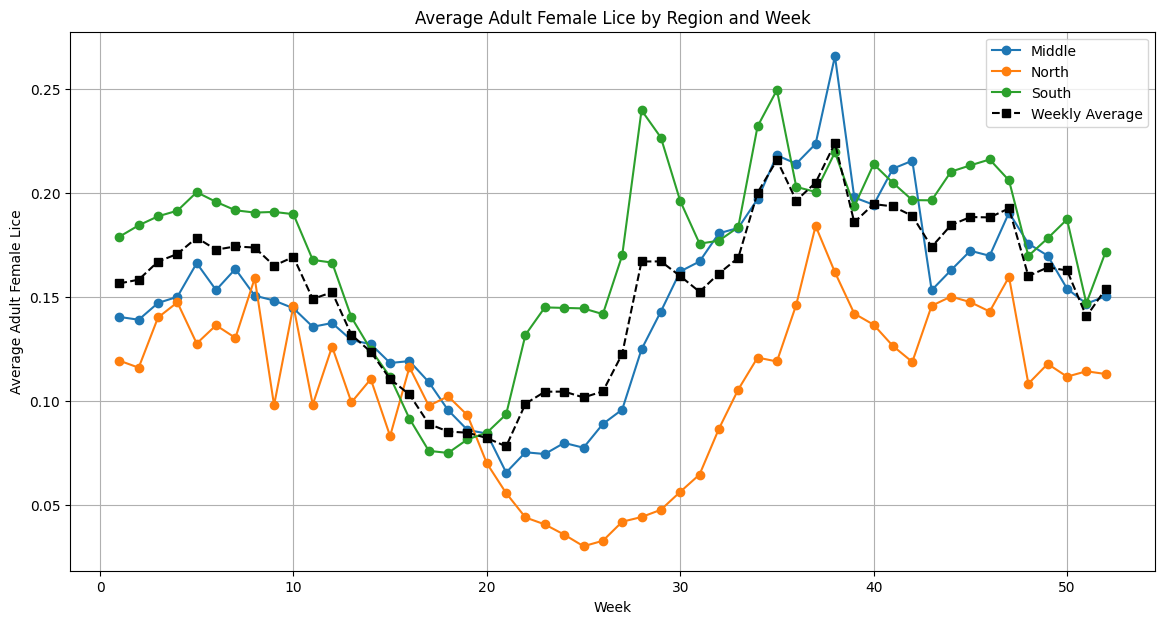

In [14]:
# Reset index to use 'week' as a column
pivot_table_week_region.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(14, 7))

# Since we have a multi-index, we'll plot each region separately.
for region in pivot_table_week_region['region'].unique():
    # Select data for the region
    region_data = pivot_table_week_region[pivot_table_week_region['region'] == region]
    plt.plot(region_data['week'], region_data['avgadultfemalelice'], marker='o', label=region)
plt.plot(weekly_avg['week'], weekly_avg['avgadultfemalelice'], marker='s', color='black', linestyle='--', label='Weekly Average')


plt.legend()
plt.xlabel('Week')
plt.ylabel('Average Adult Female Lice')
plt.title('Average Adult Female Lice by Region and Week')
plt.grid(True)


plt.show()

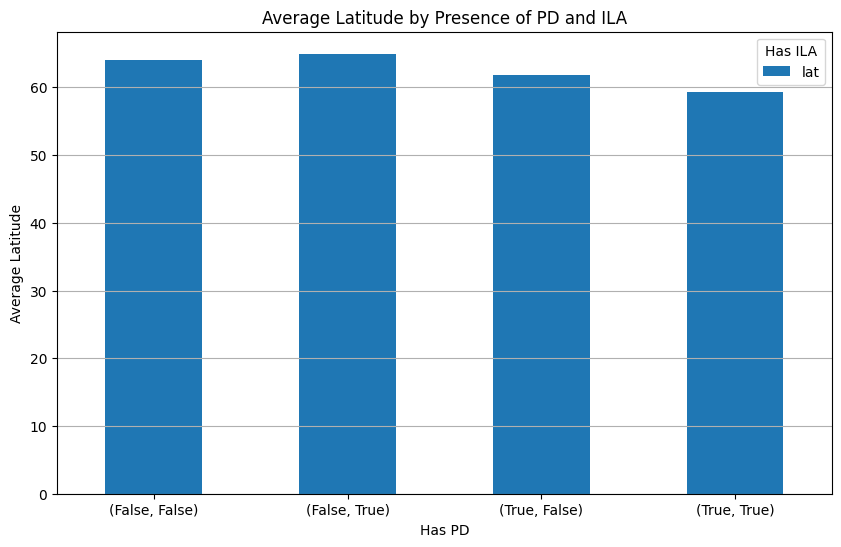

In [15]:
pivot_table_pd_ila.plot(kind='bar', figsize=(10, 6))

# Add legend and labels
plt.legend(title='Has ILA')
plt.xlabel('Has PD')
plt.ylabel('Average Latitude')
plt.title('Average Latitude by Presence of PD and ILA')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

#this plot really dosen't show much, so lets try something else

In [16]:
pivot_table_pd_long = locations_df.pivot_table(index=['haspd', 'hasila'], values=['lon', 'lat'], aggfunc='mean') # get the long and lat for precise location

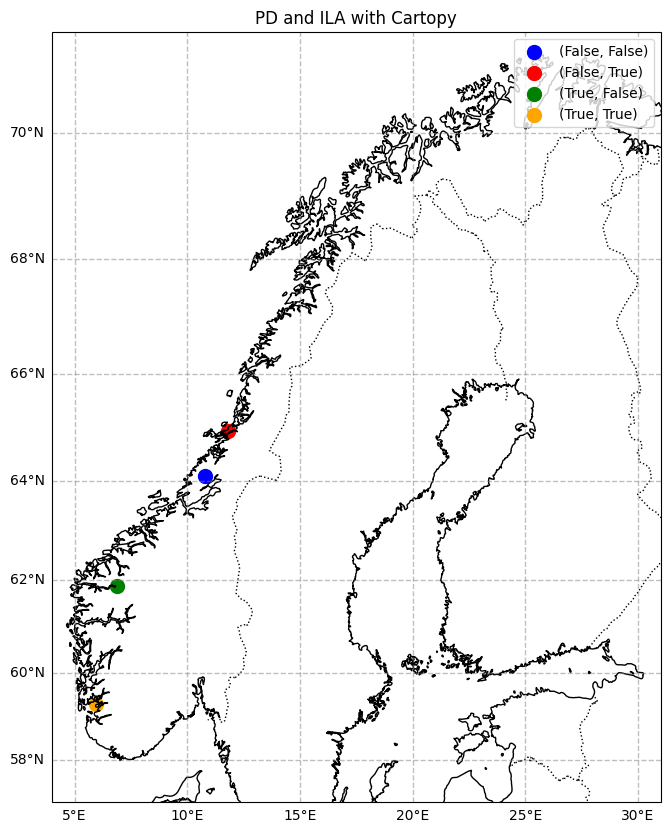

In [17]:
proj = ccrs.Mercator()
transform = ccrs.Geodetic()
fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 10))


ax.set_extent([4.0, 31.0, 57.0, 71.0], crs=transform)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')



color_map = {
    (False, False): 'blue',
    (True, False): 'green',
    (True, True): 'orange',
    (False, True): 'red'
}


for index, row in pivot_table_pd_long.iterrows():
    lon, lat = row['lon'], row['lat']
    color = color_map.get(index)  
    ax.scatter(lon, lat, color=color, s=100, transform=transform, label=str(index))

ax.legend(loc='upper right')


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


plt.title('PD and ILA with Cartopy')


plt.show()

### Comments

We can see, based on the map, that Ila and PD together are most common down south in Norway around Stavanger, while Ila alone is more common up north around Bindal. But it looks like it dosent really follow a patttern, even though there is not enough data to say anything for sure.

From the female lice plotting, we can see that the lice is most common in the beginning and end of the year, with almost a periodic structure. This is probably because the lice is less activate in the warmer months, and more active in the colder ones, for some unknown reason.

We also see that the least amount of female lice is up north, and most is down south. While middle of Norway seems to almost follow the overall average in the country.

## Forecasting

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [19]:
lice_df.isnull().sum()

week                  0
localityno            0
avgadultfemalelice    7
avgmobilelice         7
avgstationarylice     7
hasreportedlice       0
seatemperature        8
year                  0
dtype: int64

In [20]:
lice_df_2 = lice_df.dropna()
#Optionaly we can ffil

In [21]:
lice_df_2.isnull().sum()

week                  0
localityno            0
avgadultfemalelice    0
avgmobilelice         0
avgstationarylice     0
hasreportedlice       0
seatemperature        0
year                  0
dtype: int64

In [22]:
# set index to week
lice_df_2.set_index('week', inplace=True)

In [23]:
print(type(lice_df_2))

<class 'pandas.core.frame.DataFrame'>


In [24]:
def plot_rolling_correlations(window_width, lag):
    fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    colors = ['r', 'g', 'b']
    color_index = (lag-1) % len(colors)

    lice_df_2['seatemperature_lagged'] = lice_df_2['seatemperature'].shift(lag)

    rolling_corr_af = lice_df_2['seatemperature_lagged'].rolling(window=window_width).corr(lice_df_2['avgadultfemalelice'])
    rolling_corr_ml = lice_df_2['seatemperature_lagged'].rolling(window=window_width).corr(lice_df_2['avgmobilelice'])
    rolling_corr_sl = lice_df_2['seatemperature_lagged'].rolling(window=window_width).corr(lice_df_2['avgstationarylice'])

    # Calculate the center for each correlation series
    center_af = rolling_corr_af.idxmax()
    center_ml = rolling_corr_ml.idxmax()
    center_sl = rolling_corr_sl.idxmax()

    # Calculate start and end indices for each time series plot
    start_idx_af = max(center_af - window_width//2, 0)
    end_idx_af = min(center_af + window_width//2, len(lice_df_2))

    start_idx_ml = max(center_ml - window_width//2, 0)
    end_idx_ml = min(center_ml + window_width//2, len(lice_df_2))

    start_idx_sl = max(center_sl - window_width//2, 0)
    end_idx_sl = min(center_sl + window_width//2, len(lice_df_2))

    # Plot for seatemperature with red line
    axes[0].plot(lice_df_2['seatemperature'], label='Sea Temperature')
    axes[0].plot(lice_df_2['seatemperature'][start_idx_af:end_idx_af], color="red")
    axes[0].set_ylabel('Sea Temperature')

    # Plot for avgadultfemalelice with red line
    axes[1].plot(lice_df_2['avgadultfemalelice'], label='Avg Adult Female Lice')
    axes[1].plot(lice_df_2['avgadultfemalelice'][start_idx_ml:end_idx_ml], color="red")
    axes[1].set_ylabel('Avg Adult Female Lice')

    # Rolling Correlation Plots with correct centers and red lines
    axes[2].plot(rolling_corr_af, color=colors[color_index], label=f'Lag {lag}')
    axes[2].axvline(center_af, color='g', linestyle='--')
    axes[2].set_title('Rolling Correlation - Avg Adult Female Lice')

    axes[3].plot(rolling_corr_ml, color=colors[color_index], label=f'Lag {lag}')
    axes[3].axvline(center_ml, color='g', linestyle='--')
    axes[3].set_title('Rolling Correlation - Avg Mobile Lice')

    axes[4].plot(rolling_corr_sl, color=colors[color_index], label=f'Lag {lag}')
    axes[4].axvline(center_sl, color='g', linestyle='--')
    axes[4].set_title('Rolling Correlation - Avg Stationary Lice')

    for ax in axes:
        ax.legend()
        ax.grid(True)

    axes[4].set_xlabel('Time')

    plt.tight_layout()
    plt.show()


interact(plot_rolling_correlations, window_width=widgets.IntSlider(min=2, max=30, step=1, value=10), lag=widgets.IntSlider(min=1, max=10, step=1, value=1))



interactive(children=(IntSlider(value=10, description='window_width', max=30, min=2), IntSlider(value=1, descr…

<function __main__.plot_rolling_correlations(window_width, lag)>

I dont fully understand the correlation plot, but it seems like its a correlation in the beginning of the plot, but then it dies of as the weeks increase. 
It can be that the weather has a big impact wether its cold or hot, and this brings forth either negative or positive correlation.


There also seems to be better plots to visualize the correlation (not a heatmap), but I will have to figure it out untill the next assignment.

### commentary about the correlation between lice and sea temperature

### Machine learning analysis

In [25]:
sar_weather_lice = weather_lice_df.sort_values(by=['week']).copy()

In [26]:
lice_df_2.reset_index(inplace=True)

In [27]:
sar_weather_lice = sar_weather_lice.merge(lice_df_2[['week', 'seatemperature']], on='week', how='left') # merge the two dataframes on the common week column

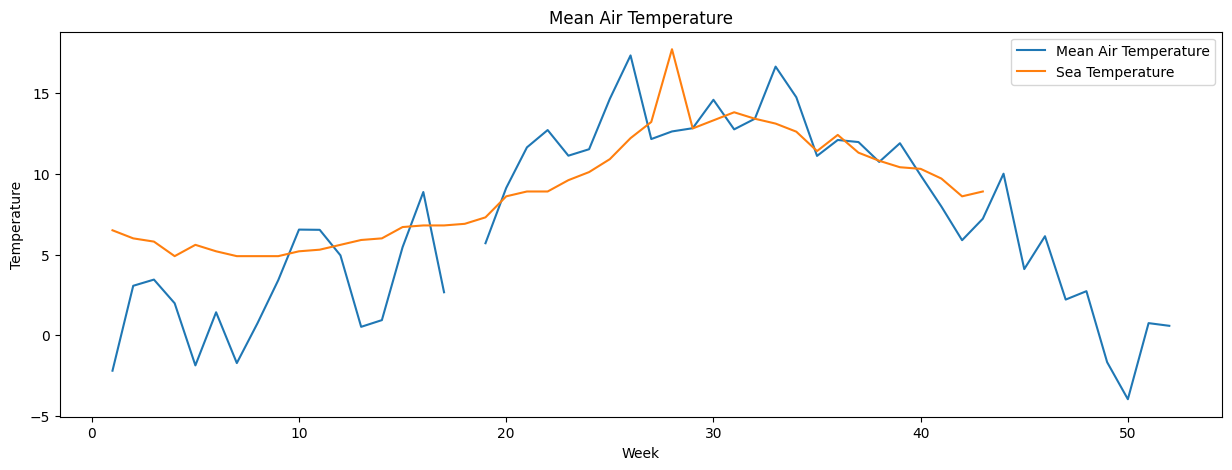

In [28]:
#plot both sea temperature and mean air temperature to check if everything is ok
plt.figure(figsize=(15, 5))
plt.plot(sar_weather_lice['week'],sar_weather_lice['mean_air_temperature'])
plt.plot(sar_weather_lice['week'],sar_weather_lice['seatemperature'])
plt.title('Mean Air Temperature')
plt.xlabel('Week')
plt.ylabel('Temperature')
plt.legend(['Mean Air Temperature', 'Sea Temperature'])
plt.show()

In [29]:
#set index to week
sar_weather_lice.set_index('week', inplace=True)

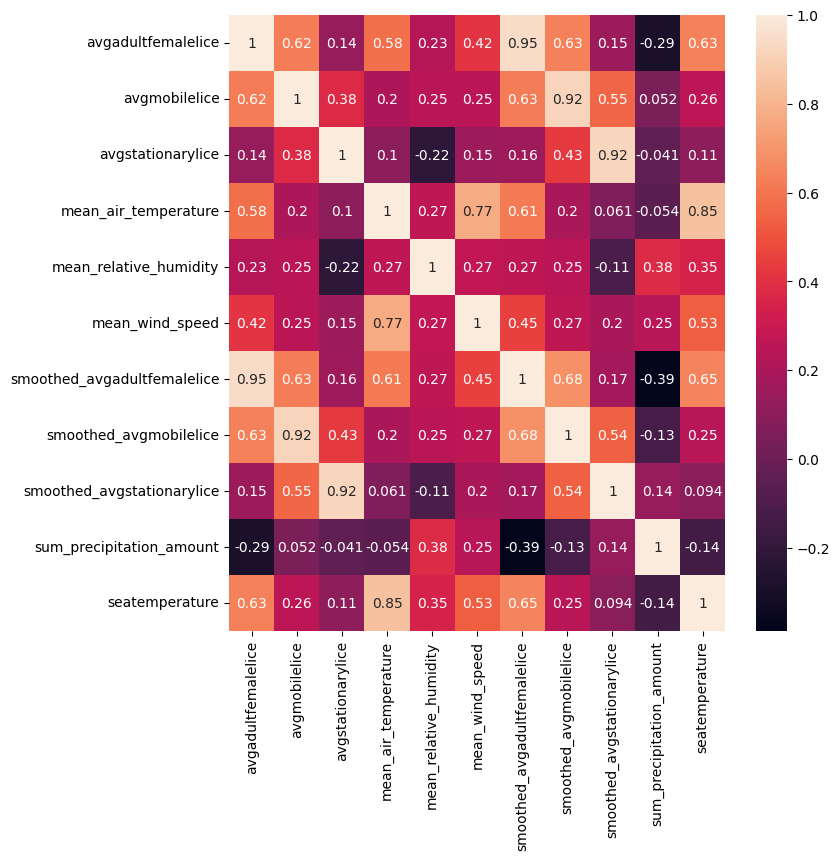

In [30]:
#plot heat map to check for correlation
plt.figure(figsize=(8, 8))
sns.heatmap(sar_weather_lice.corr(), annot=True)
plt.show()


In [31]:
sar_weather_lice.dropna(inplace=True)

sar_weather_lice.isna().sum()

avgadultfemalelice             0
avgmobilelice                  0
avgstationarylice              0
mean_air_temperature           0
mean_relative_humidity         0
mean_wind_speed                0
smoothed_avgadultfemalelice    0
smoothed_avgmobilelice         0
smoothed_avgstationarylice     0
sum_precipitation_amount       0
seatemperature                 0
dtype: int64

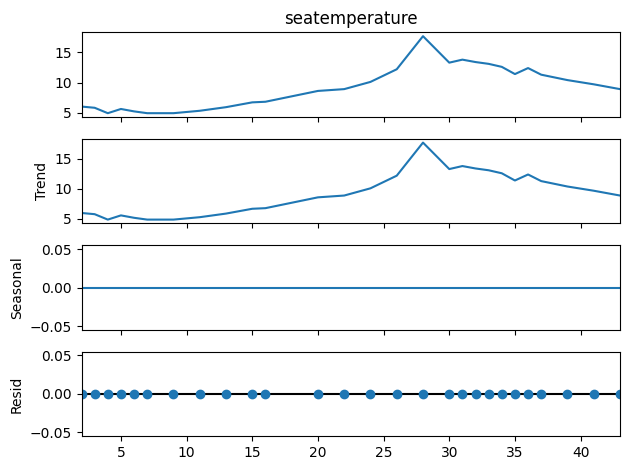

In [32]:
result = seasonal_decompose(sar_weather_lice['seatemperature'], model='additive', period = 1)

result.plot()
plt.show()

There is high correlation between a lot of columns, which is a good sign that we have good quality data to work with 

In [33]:
lagged_columns = ['mean_air_temperature', 'mean_relative_humidity', 
                  'mean_wind_speed', 'sum_precipitation_amount']
for col in lagged_columns:
    sar_weather_lice[col + '_lag1'] = sar_weather_lice[col].shift(1)


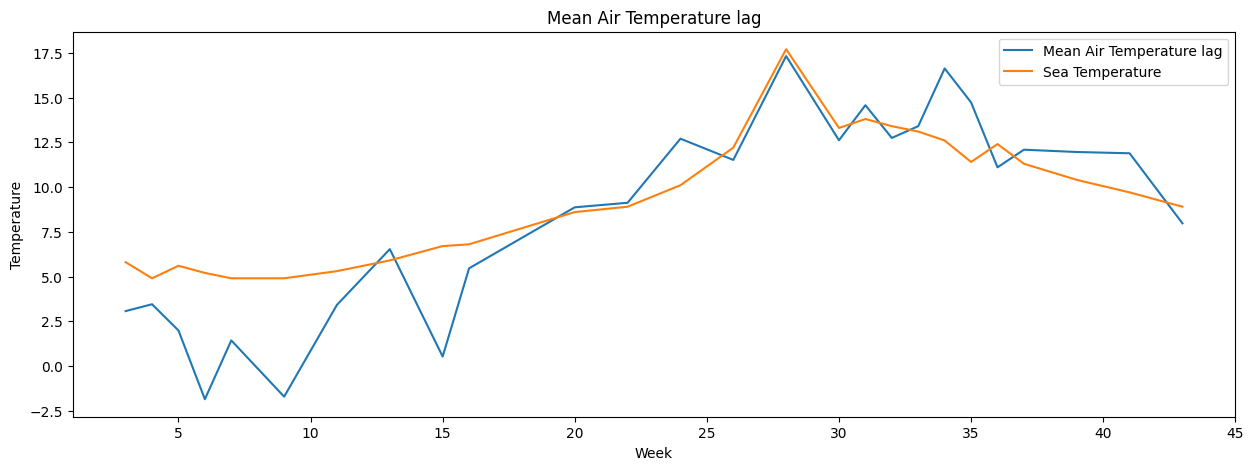

In [34]:
sar_weather_lice.dropna(inplace=True)
#plot the area where NA values are present
plt.figure(figsize=(15, 5))
plt.plot(sar_weather_lice['mean_air_temperature_lag1'])
plt.plot(sar_weather_lice['seatemperature'])
plt.title('Mean Air Temperature lag')
plt.xlabel('Week')
plt.ylabel('Temperature')
plt.legend(['Mean Air Temperature lag', 'Sea Temperature'])

In [35]:
# only keep the lags and the sea temperature
weather_lice_lag= sar_weather_lice[['seatemperature', 'mean_air_temperature_lag1', 'mean_relative_humidity_lag1', 'mean_wind_speed_lag1', 'sum_precipitation_amount_lag1']].copy()

weather_lice_lag.head()

,seatemperature,mean_air_temperature_lag1,mean_relative_humidity_lag1,mean_wind_speed_lag1,sum_precipitation_amount_lag1
week,,,,,
3,5.8,3.066667,69.0,61.069231,10.364286
4,4.9,3.450000,90.0,62.084615,16.478571
5,5.6,1.985714,93.0,79.000000,13.514286
6,5.2,-1.857143,72.0,28.176923,2.700000
7,4.9,1.428571,87.0,67.307692,10.392857


In [36]:
train = weather_lice_lag.iloc[:-10]  
test = weather_lice_lag.iloc[-10:]  

In [37]:
# Define the target variable and exogenous variables
target = 'seatemperature'
exog_vars = ['mean_air_temperature_lag1', 'mean_relative_humidity_lag1', 'mean_wind_speed_lag1', 'sum_precipitation_amount_lag1']

In [38]:
auto_arima_model = pm.auto_arima(train[target], seasonal=True, exogenous=train[exog_vars], m = 7,
                                 trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=75.378, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=66.792, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=68.521, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=68.858, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=65.735, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=68.706, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=68.735, Time=0.01 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=66.703, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=67.029, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=68.675, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 0.687 seconds


In [39]:
# Best model parameters
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -31.868
Date:                Tue, 28 Nov 2023   AIC                             65.735
Time:                        10:29:00   BIC                             66.443
Sample:                             0   HQIC                            65.728
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.1006      1.028      3.991      0.000       2.087       6.114
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 3.83
Prob(Q):                              0.25   Pr

In [40]:
arimax_model = SARIMAX(train[target], exog=train[exog_vars], 
                       order=auto_arima_model.order, seasonal_order=auto_arima_model.seasonal_order)
arimax_results = arimax_model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54210D+00    |proj g|=  1.50644D-01

At iterate    5    f=  1.71021D+00    |proj g|=  2.04990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     16      1     0     0   2.191D-04   1.710D+00
  F =   1.7102054531873210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


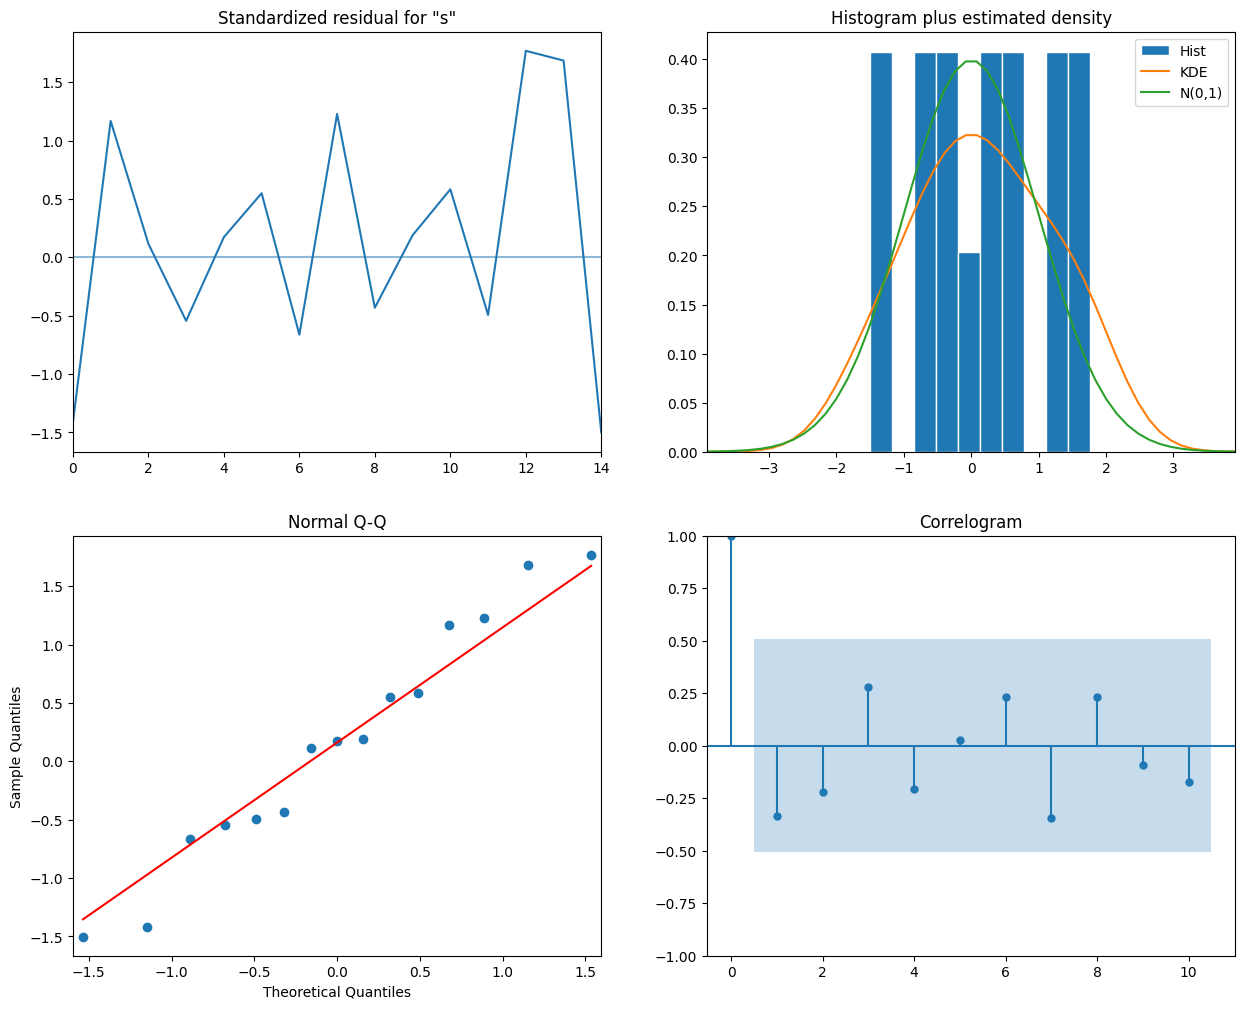

In [41]:
# Plot the residuals
arimax_results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [42]:
st = len(test)
predictions = arimax_results.get_forecast(steps=st, exog= test[exog_vars])

predictions_mean = predictions.predicted_mean

#make df for predictions
predictions_df = pd.DataFrame(predictions_mean)

#set index to week
predictions_df.set_index(test.index, inplace=True)

predictions_df.head()

/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
week,
31,13.946490
32,13.227562
33,13.170767
34,15.161779
35,14.156285


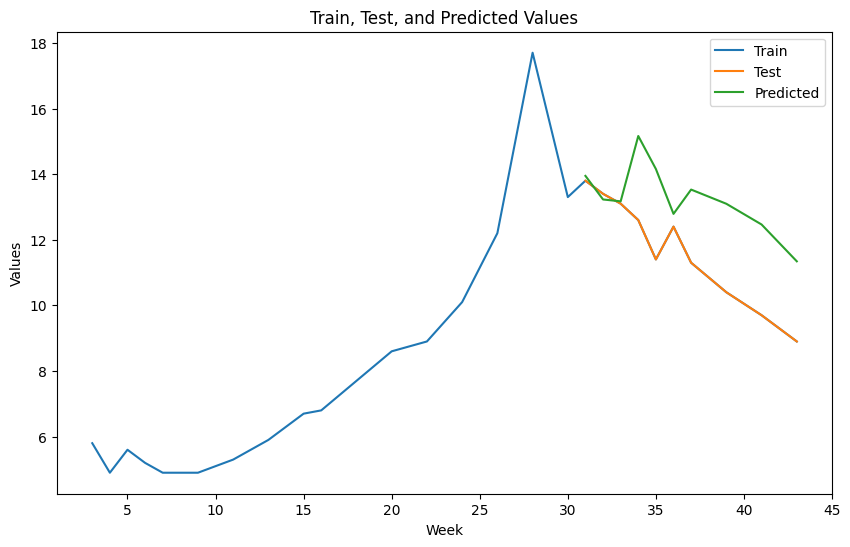

In [43]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weather_lice_lag[target], label='Train')
plt.plot(test[target], label='Test')
plt.plot(predictions_df, label='Predicted')
plt.xlabel('Week')
plt.ylabel('Values')
plt.title('Train, Test, and Predicted Values')
plt.legend()

# Show plot
plt.show()


In [44]:
test.tail()

,seatemperature,mean_air_temperature_lag1,mean_relative_humidity_lag1,mean_wind_speed_lag1,sum_precipitation_amount_lag1
week,,,,,
36,12.4,11.100000,79.0,74.307692,0.778571
37,11.3,12.085714,87.0,77.153846,0.000000
39,10.4,11.957143,89.0,88.846154,2.557143
41,9.7,11.885714,68.0,75.000000,0.007143
43,8.9,7.971429,82.5,82.416667,6.835714


In [45]:
train.tail()

,seatemperature,mean_air_temperature_lag1,mean_relative_humidity_lag1,mean_wind_speed_lag1,sum_precipitation_amount_lag1
week,,,,,
22,8.9,9.120000,64.0,75.833333,0.735714
24,10.1,12.700000,75.5,78.000000,5.321429
26,12.2,11.514286,84.0,91.916667,5.900000
28,17.7,17.316667,89.0,82.500000,6.221429
30,13.3,12.614286,84.0,82.750000,4.242857


In [46]:
predictions

###  Predicting with Xgboost

In [47]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Define the model
xg_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the grid search
grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Train the grid searc
grid_search.fit(train[exog_vars], train[target])


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_est

23/11/28 10:29:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


[CV] END gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=400; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.05, max_depth=6, n_estimators=300; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.05, max_depth=6, n_estimators=500; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.05, max_depth=7, n_estimators=400; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=4, n_estimators=300; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.05, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END gamma=0.4, learning_rate=0.05, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END gamma=0

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [48]:
#print the best parameters
print(grid_search.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}


In [49]:
# Define the model with the best parameters
best_params = grid_search.best_params_
xg_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

# Train the model
xg_model.fit(train[exog_vars], train[target])





XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [50]:
# Prepare the test data
X_test = test[exog_vars]

# Make predictions
xg_predictions = xg_model.predict(X_test)

# Convert predictions to a DataFrame
xg_predictions_df = pd.DataFrame(xg_predictions, index=test.index, columns=['predicted_seatemperature'])


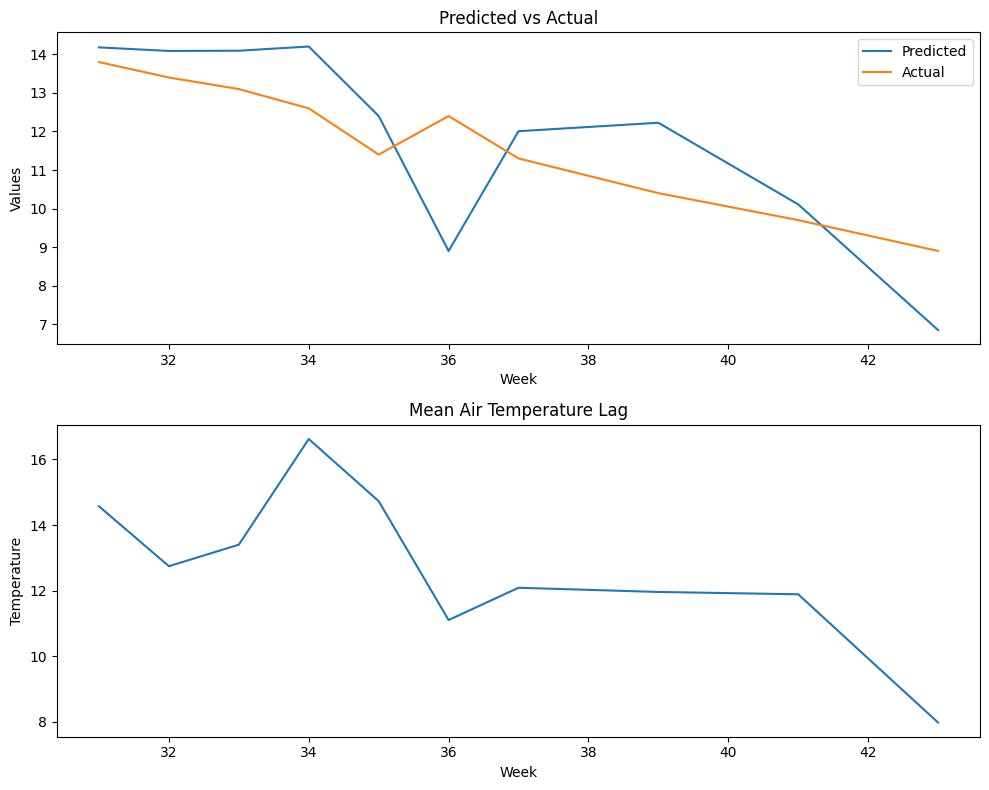

In [51]:
#plot the predictions and mean_air_temperature_lag1 in subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the predictions
axes[0].plot(xg_predictions_df, label='Predicted')
axes[0].plot(test[target], label='Actual')
axes[0].set_title('Predicted vs Actual')
axes[0].set_xlabel('Week')
axes[0].set_ylabel('Values')
axes[0].legend()

# Plot the mean_air_temperature_lag1
axes[1].plot(test['mean_air_temperature_lag1'])
axes[1].set_title('Mean Air Temperature Lag')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Temperature')

plt.tight_layout()
plt.show()


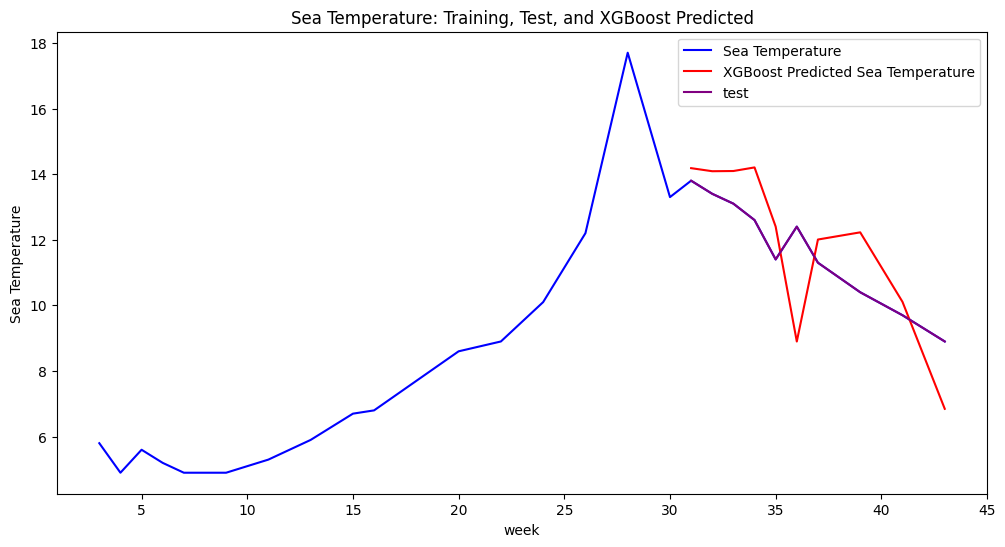

In [52]:
plt.figure(figsize=(12, 6))

plt.plot(weather_lice_lag['seatemperature'], color='blue', label='Sea Temperature')
plt.plot(xg_predictions_df, color='red', label='XGBoost Predicted Sea Temperature')
plt.plot(test[target], color='purple', label='test')
plt.title('Sea Temperature: Training, Test, and XGBoost Predicted')
plt.xlabel('week')
plt.ylabel('Sea Temperature')
plt.legend()
plt.show()


The xgboost prediction makes so much more sense, maybe the data has been filled in wrong, or has some fault with it, to solve this problem we can rather focus on the 30 to 40 part, and drop the last 10 rows of data

### Preparing for CA4

In [53]:
#exporting data as csv 
weather_lice_lag.to_csv('weather_lice_lag.csv')
lice_df_2.to_csv('lice_df_2.csv')
sar_weather_lice.to_csv('sar_weather_lice.csv')
predictions_df.to_csv('predictions_df.csv')
xg_predictions_df.to_csv('xg_predictions_df.csv')

